# CNNの性能評価

In [1]:
import importlib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pickle
from pprint import pprint
import sklearn
from sklearn import datasets
from sklearn.cluster import KMeans, MeanShift, AgglomerativeClustering
from sklearn.manifold import TSNE, MDS, SpectralEmbedding
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.spatial import distance
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets,models, transforms
from tqdm import tqdm

In [2]:
sys.path.append("/home/kwk/share/mizuho/u00257/vae_clustering/src/")
sys.path.append("/home/kwk/share/mizuho/u00257/vae_clustering/src/lib/")
sys.path.append("/home/kwk/share/mizuho/u00257/vae_clustering/src/data_pkls/")

In [51]:
from vae_datasets import dataset2d
from vae_models import ConvVAE_224
from cnn_dataset import cnn_dataset
import img_shows
importlib.reload(img_shows)
from img_shows import *

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [5]:
batch_size = 1
num_clusters = 20
data_pkls = "../data_pkls/imgs224_40_123m/"
pkl_files = [data_pkls + str(i+1) + ".pkl" for i in range(10, 30)]
data_pkls = "../data_pkls/labels/"
pkl_labels = data_pkls + "labels" + str(num_clusters) +  "_23m" + ".pkl"
dataset = cnn_dataset(pkl_files, pkl_labels, classes=num_clusters)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=False)

In [6]:
data_pkls = "../data_pkls/"
dates = None
with open(data_pkls + "dates123m.pkl", "rb") as pkl:
    dates = pickle.load(pkl)
print(len(dates))
len1 = 14513
pos2 = 28994
len2 = pos2 - len1
len3 = len(dates) - pos2
print(len1, len2, len3)
print(len(dates))
dates = dates[len1:]
data_size = len(dates)
print(data_size)

43446
14513 14481 14452
43446
28933


In [7]:
model_name = "cnn20classes"
net = models.vgg16()
net.classifier[6] = nn.Linear(in_features=4096, out_features=num_clusters)
net.load_state_dict(torch.load("../model_pths/" + model_name + ".pth"))
net.eval()
net.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [13]:
img, label = dataset[14070]
print(torch.unsqueeze(img, 0).shape)
with torch.no_grad():
    output = F.softmax(net(torch.unsqueeze(img, 0)))
print(label)
print(torch.argmax(output[0]))

torch.Size([1, 3, 224, 224])
3
tensor(3, device='cuda:0')


/home/u00257/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.


## 実際に全データを分類する

In [19]:
preds = []
with torch.no_grad():
    for img, _ in dataloader:
        pred = torch.argmax(F.softmax(net(img))[0])
        preds.append(pred)

/home/u00257/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.


In [41]:
for i in range(num_clusters):
    print(i, np.count_nonzero(dataset.labels == i))

0 1085
1 967
2 2589
3 1414
4 1064
5 1340
6 1743
7 1058
8 1183
9 1197
10 1231
11 1206
12 1744
13 1494
14 1232
15 2024
16 1491
17 1566
18 2001
19 1304


In [33]:
preds = np.array([pred.to("cpu").numpy() for pred in preds], dtype="int32")

In [37]:
with open(data_pkls + "cnn_predict.pkl", "wb") as f:
    pickle.dump(preds, f)

In [40]:
for i in range(num_clusters):
    print(i, np.count_nonzero(preds == i))

0 1068
1 968
2 2606
3 1456
4 1055
5 1314
6 1799
7 1097
8 1145
9 1197
10 1265
11 1170
12 1696
13 1452
14 1289
15 2001
16 1510
17 1526
18 2028
19 1291


## 日付が近いものを除外したい

In [78]:
indices = np.array(list(range(data_size))[::50])
print(indices.shape)

(579,)


In [79]:
pred_sparse = preds[indices]

In [80]:
v_label = 10
np.where(pred_sparse==v_label)[0]

array([  2,  64, 103, 128, 182, 183, 198, 202, 203, 234, 248, 291, 292,
       353, 417, 418, 473, 484, 485, 486, 487, 491, 493, 523, 536])

In [81]:
poses = indices[np.where(pred_sparse==v_label)[0]]

In [83]:
poses

array([  100,  3200,  5150,  6400,  9100,  9150,  9900, 10100, 10150,
       11700, 12400, 14550, 14600, 17650, 20850, 20900, 23650, 24200,
       24250, 24300, 24350, 24550, 24650, 26150, 26800])

<Figure size 432x288 with 0 Axes>

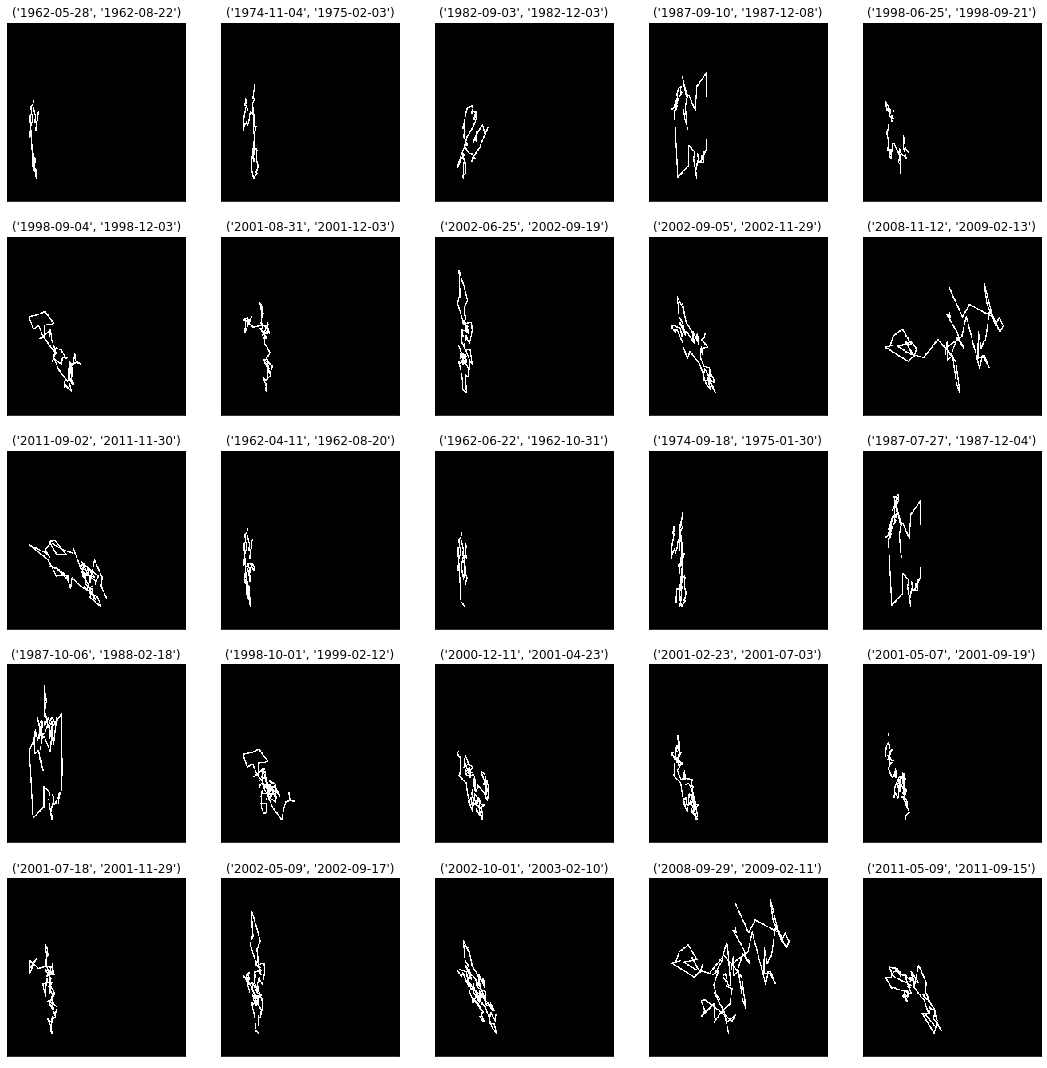

In [82]:
imshow_cnn(dataset, dates, poses)

## 最も近いものを取ってくる

In [98]:
import heapq
class priority_queue:
    def __init__(self):
        self.key = lambda item: item[0] #アイテムの優先順位を指定
        self.index = 0
        self.data = []

    def push(self, item):
        heapq.heappush(self.data, (self.key(item), self.index, item))
        self.index += 1

    def pop(self):
        return heapq.heappop(self.data)

In [106]:
def get_nearest(pos, dataset, poses = None, n = 10):
    img, _ = dataset[pos]
    pq = priority_queue()
    if poses is None:
        for i, (iter_img, _) in enumerate(dataset):
            dist = distance.euclidean(iter_img[0].flatten().to("cpu").numpy(), img[0].flatten().to("cpu").numpy())
            pq.push([dist, i])
    else:
        for iter_pos in poses:
            iter_img, _ = dataset[iter_pos]
            dist = distance.euclidean(iter_img[0].flatten().to("cpu").numpy(), img[0].flatten().to("cpu").numpy())
            pq.push([dist, iter_pos])
    n_poses = []
    for i in range(n + 1):
        n_poses.append(pq.pop()[2][1])
    return n_poses[1:]

In [108]:
print(poses)
pos = poses[20]
print(pos)
n = 4

[  100  3200  5150  6400  9100  9150  9900 10100 10150 11700 12400 14550
 14600 17650 20850 20900 23650 24200 24250 24300 24350 24550 24650 26150
 26800]
24350


<Figure size 432x288 with 0 Axes>

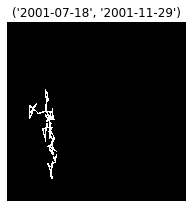

In [109]:
imshow_cnn(dataset, dates, [pos], figsize=(3,3))

[9900, 100, 9100, 14600]


<Figure size 432x288 with 0 Axes>

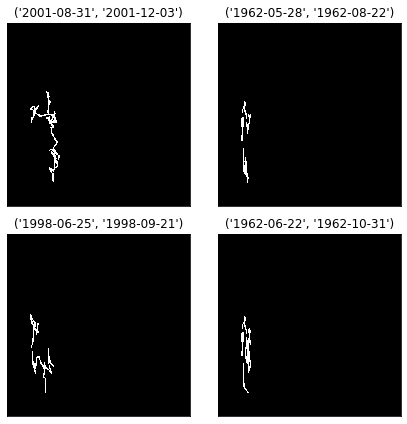

In [110]:
nearest_poses = get_nearest(pos, dataset, poses, n)
print(nearest_poses)
imshow_cnn(dataset, dates, nearest_poses, figsize=(6,6))

## バーナンキショックとVIXショックの画像を見てみる(Katafuchiさんの方で確認済み)